In [1]:
!pip install yahoofinancials mpld3 pyit2fls

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from yahoofinancials import YahooFinancials
%matplotlib inline
import mpld3
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
from pyit2fls import IT2FS_Gaussian_UncertStd, crisp, IT2FS_plot

mpld3.enable_notebook()

BATCH_SIZE = 20


In [3]:
end_date = datetime.today()
start_date = end_date - timedelta(days=15 * 365)
ticker = 'A17U.SI'
df = yf.download(ticker, start=start_date, end=end_date)

short_term_window_size = 20
long_term_window_size = 100

# Calculate the moving averages
df['Price_Diff'] = df['Close'].diff()
df['Volatility'] = df['Close'].rolling(window=short_term_window_size).std()

df['Short_Term_Diff'] = df['Close'] - df['Close'].shift(short_term_window_size)
df['Long_Term_Diff'] = df['Close'] - df['Close'].shift(long_term_window_size)

df['Short_Term_SMA'] = df['Close'].rolling(window = short_term_window_size, min_periods = 1).mean()
df['Long_Term_SMA'] = df['Close'].rolling(window = long_term_window_size, min_periods = 1).mean()

df = df.iloc[long_term_window_size:]

df.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume,Price_Diff,Volatility,Short_Term_Diff,Long_Term_Diff,Short_Term_SMA,Long_Term_SMA
Ticker,A17U.SI,A17U.SI,A17U.SI,A17U.SI,A17U.SI,A17U.SI,,,,,,
Date,,,,,,,,,,,,
2010-04-22 00:00:00+00:00,0.836125,1.942930,1.962457,1.933166,1.933166,5956899,0.000000,0.020742,0.068345,0.107398,1.916080,1.914616
2010-04-23 00:00:00+00:00,0.839235,1.923403,1.923403,1.903876,1.923403,4727828,-0.019527,0.020134,0.029291,0.039054,1.917545,1.915006
2010-04-26 00:00:00+00:00,0.830714,1.903876,1.933166,1.903876,1.933166,2257394,-0.019527,0.020134,0.000000,0.048818,1.917545,1.915494
2010-04-27 00:00:00+00:00,0.817934,1.874585,1.894112,1.864822,1.894112,9019335,-0.029291,0.022236,-0.048818,0.029290,1.915104,1.915787
2010-04-28 00:00:00+00:00,0.809414,1.855058,1.874585,1.825768,1.855058,9260028,-0.019527,0.025851,-0.068345,-0.039054,1.911687,1.915397


In [4]:
##LSTM - Benchmark Model

In [5]:
short_term_window_size = 20
#mid_term_window_size = 30
long_term_window_size = 100

# 2. Prepare the Dataset with Selected Features
features = df[['Open', 'High', 'Low', 'Close', 'Price_Diff', 'Short_Term_Diff', 'Long_Term_Diff', 'Short_Term_SMA', 'Long_Term_SMA', 'Volatility', 'Volume']]
# Normalize the data for stability
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

In [6]:
# 3. Create Sequences for LSTM Input
sequence_length = 30  # Use the last 30 days of data to predict the next day
X, y = [], []
for i in range(sequence_length, len(scaled_features)):
    X.append(scaled_features[i-sequence_length:i])  # Last 30 days of features
    y.append(scaled_features[i, 0])  # Next day's closing price as the target

# Convert lists to numpy arrays
X, y = np.array(X), np.array(y)

# 4. Split the Data into Training and Testing Sets
train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [7]:
# 5. Define the LSTM Model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)  # Output layer with one unit (predicting the closing price)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 6. Train the Model
history = model.fit(X_train, y_train, epochs=50, batch_size=20, validation_data=(X_test, y_test))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.0075 - val_loss: 0.0015
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 7.5419e-04 - val_loss: 5.4689e-04
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 6.6827e-04 - val_loss: 4.0751e-04
Epoch 4/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.8100e-04 - val_loss: 4.4574e-04
Epoch 5/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.8338e-04 - val_loss: 4.2478e-04
Epoch 6/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.7949e-04 - val_loss: 1.6009e-04
Epoch 7/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.4343e-04 - val_loss: 1.2998e-04
Epoch 8/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.7375e-04 - val_loss: 2.0879e-04
Epoch 9/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.5890e-04 - val_loss: 1.8439e-04
Epoch 10/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3731e-04 - val_loss: 1.6482e-04
Epoch 11/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.

In [8]:
#Fuzzy LSTM

#df[['Price_Diff', 'Close', 'LSTM_Fast_SMA', 'LSTM_Slow_SMA']]
features_n_clusters = [6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 3]

def clustering_features(features, features_n_clusters): #Get cluster centers, means and sigmas for each features given the number of clusters.

  cluster_centers = []
  cluster_means = []
  cluster_sigmas = []

  for i in range(scaled_features.shape[1]):

    n_clusters = features_n_clusters[i]
    feature_datas = scaled_features[:,i].reshape(-1, 1)

    kmeans = KMeans(n_clusters, random_state=42)
    kmeans.fit(feature_datas)

    centers = kmeans.cluster_centers_.flatten().tolist()
    labels = kmeans.labels_ #Calculate means and sigmas for each cluster

    means = []
    sigmas = []

    for i in range(n_clusters):
      cluster_points = feature_datas[labels == i]
      cluster_mean = np.mean(cluster_points)
      cluster_sigma = np.std(cluster_points)

      means.append(cluster_mean)
      sigmas.append(cluster_sigma)

    sorted_cluster_features = sorted(zip(centers, means, sigmas), key=lambda x: x[0])
    centers, means, sigmas = map(list, zip(*sorted_cluster_features))


    cluster_centers.append(centers)
    cluster_means.append(means)
    cluster_sigmas.append(sigmas)


  return cluster_centers, cluster_means, cluster_sigmas


def generate_it2fmf(cluster_means, cluster_sigmas):

  num_features = len(cluster_means)
  it2fmf = []
  for i in range(num_features):
    feature_cluster_means = cluster_means[i]
    feature_cluster_sigmas = cluster_sigmas[i]
    feature_fmf_list = []

    for j in range(len(feature_cluster_means)):
      cluster_mean = feature_cluster_means[j]
      cluster_sigma = feature_cluster_sigmas[j]

      fmf = IT2FS_Gaussian_UncertStd((0, 1), [cluster_mean, cluster_sigma, cluster_sigma/2, 1.])
      feature_fmf_list.append(fmf)
    it2fmf.append(feature_fmf_list)
  return it2fmf


cluster_centers, cluster_means, cluster_sigmas = clustering_features(scaled_features, features_n_clusters)
it2fmf = generate_it2fmf(cluster_means, cluster_sigmas)

In [9]:
class FuzzyLayer(tf.keras.layers.Layer):
    def __init__(self, it2fmf):
        """
        Custom Fuzzy Layer.
        Parameters:
        - it2fmf: List of fuzzy membership functions for each feature.
        """
        super(FuzzyLayer, self).__init__()
        self.it2fmf = it2fmf  # Precomputed fuzzy membership functions
        self.fmf_count = 0
        for feature_fmf_list in it2fmf:
            self.fmf_count += len(feature_fmf_list)

    def call(self, inputs):
        """
        Compute fuzzy membership degrees for the input features.
        Parameters:
        - inputs: Input tensor of shape (batch_size, num_features).
        Returns:
        - fuzzified_inputs: Tensor of shape (batch_size, num_features, num_memberships).
        """
        feature_membership_values = []
        for i, feature_fmf_list in enumerate(self.it2fmf):
            feature_values = inputs[:, :, i:i+1]  # Extract the i-th feature (shape: batch_size, 1)
            # Compute fuzzy membership degrees for each fuzzy set in the feature
            for fmf in feature_fmf_list:
                # Compute the upper and lower membership degrees
                umf_values = tf.numpy_function(
                    lambda vals: tf.convert_to_tensor([fmf.umf(x, fmf.umf_params) for x in vals]),
                    [feature_values],
                    tf.float32
                )
                lmf_values = tf.numpy_function(
                    lambda vals: tf.convert_to_tensor([fmf.umf(x, fmf.lmf_params) for x in vals]),
                    [feature_values],
                    tf.float32
                )
                feature_membership_values.append(tf.squeeze(umf_values, axis=2))
                feature_membership_values.append(tf.squeeze(lmf_values, axis=2))
        stacked_membership_values = tf.stack(feature_membership_values, axis=0)
        fuzzified_inputs = tf.transpose(stacked_membership_values, perm=[1, 2, 0])
        fuzzified_inputs = tf.reshape(fuzzified_inputs, (-1, inputs.shape[1], self.fmf_count * 2))
        #fuzzified_inputs = tf.concat([inputs[:, :, 0:1], fuzzified_inputs], axis=-1)

        return fuzzified_inputs



In [10]:
fuzzy_layer = FuzzyLayer(it2fmf)

# Define the LSTM model
fuzzy_model = tf.keras.Sequential([
    fuzzy_layer,  # Add the custom fuzzy layer
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)  # Output layer with one unit (e.g., predicting the closing price)
])


# Compile the model
fuzzy_model.compile(optimizer='adam', loss='mean_squared_error')
history = fuzzy_model.fit(X_train, y_train, epochs=50, batch_size=20, validation_data=(X_test, y_test))

Epoch 1/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 39s 220ms/step - loss: 0.0396 - val_loss: 0.0087
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 36s 217ms/step - loss: 0.0034 - val_loss: 8.6146e-04
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 40s 210ms/step - loss: 0.0011 - val_loss: 6.5572e-04
Epoch 4/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 40s 207ms/step - loss: 6.4022e-04 - val_loss: 5.3452e-04
Epoch 5/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 42s 215ms/step - loss: 5.5365e-04 - val_loss: 9.5182e-04
Epoch 6/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 41s 213ms/step - loss: 0.0014 - val_loss: 0.0079
Epoch 7/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 41s 216ms/step - loss: 0.0016 - val_loss: 2.6964e-04
Epoch 8/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 48s 259ms/step - loss: 4.7597e-04 - val_loss: 2.0901e-04
Epoch 9/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 74s 214ms/step - loss: 9.3452e-04 - val_loss: 4.7088e-04
Epoch 10/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 34s 207ms/step - loss: 4.3763e-04 - val_loss: 2.6404e-04
Epoch 11/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 35s 215ms/step -

In [11]:
# 7. Make Predictions
df[('Baseline_Prediction', 'A17U.SI')] = df[('Close', 'A17U.SI')].shift(1)

y_pred_LSTM = model.predict(X_test)
y_pred_FLSTM = fuzzy_model.predict(X_test)
y_pred_baseline = np.array(df[('Baseline_Prediction', 'A17U.SI')][-len(y_test):])

# Inverse transform predictions to original scale

y_pred_rescaled_LSTM = scaler.inverse_transform(
    np.concatenate((y_pred_LSTM, np.zeros((y_pred_LSTM.shape[0], scaled_features.shape[1] - 1))), axis=1)
)[:, 0]

y_pred_rescaled_FLSTM = scaler.inverse_transform(
    np.concatenate((y_pred_FLSTM, np.zeros((y_pred_FLSTM.shape[0], scaled_features.shape[1] - 1))), axis=1)
)[:, 0]

y_test_rescaled = scaler.inverse_transform(
    np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_features.shape[1] - 1))), axis=1)
)[:, 0]

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 260ms/step


In [12]:
def calculate_transaction_signals(predicted_price, actual_price, price_change_threshold):
  # predicted_price: Rescaled predicted stock price
  # actual_price: Actual stock price
  # price_change_threshold: Set a minimum price change threshold to filter minor fluctuations
  buy_signals, sell_signals = [], []

  for i in range(1, len(predicted_price)):
    price_diff = predicted_price[i] - predicted_price[i - 1]   #was predicted_price[i] - actual_price[i - 1]
    if price_diff > price_change_threshold:  # Significant increase
        buy_signals.append(predicted_price[i])
        sell_signals.append(np.nan)
    elif price_diff < -price_change_threshold:  # Significant decrease
        sell_signals.append(predicted_price[i])
        buy_signals.append(np.nan)
    else:
        buy_signals.append(np.nan)
        sell_signals.append(np.nan)
  return buy_signals, sell_signals

In [13]:
def calculate_portfolio(buy_signals, sell_signals, actual_price, transaction_rate):


  actions = np.zeros(len(actual_price))
  for i in range(0, len(actions)-1):
      if not np.isnan(buy_signals[i]):
          actions[i] = 1  # Buy
      elif not np.isnan(sell_signals[i]):
          actions[i] = -1  # Sell
      else:
          actions[i] = 0  # Hold

  # Calculate portfolio returns based on Equation (1)
  portfolio = [1.0]  # Starting portfolio returns at 1.0 for cumulative product calculation
  for i in range(1, len(actual_price)):
      r_t = (actual_price[i] / actual_price[i - 1]) - 1  # Return rate
      action_change = abs(actions[i] - actions[i - 1])  # Change in action to capture transaction cost
      R_t = (1 + actions[i - 1] * r_t) * (1 - transaction_rate * action_change)
      portfolio.append(portfolio[-1] * R_t)
  return portfolio

In [14]:
# Caluclate LSTM Portfolio Returns

transaction_rate = 0.005  # Transaction cost rate (0.5%)

price_change_threshold = 0.01

LSTM_pred_buy_signals, LSTM_pred_sell_signals = calculate_transaction_signals(y_pred_rescaled_LSTM, y_test_rescaled, price_change_threshold)
LSTM_pred_portfolio = calculate_portfolio(LSTM_pred_buy_signals, LSTM_pred_sell_signals, y_test_rescaled, transaction_rate)

FLSTM_pred_buy_signals, FLSTM_pred_sell_signals = calculate_transaction_signals(y_pred_rescaled_FLSTM, y_test_rescaled, price_change_threshold)
FLSTM_pred_portfolio = calculate_portfolio(FLSTM_pred_buy_signals, FLSTM_pred_sell_signals, y_test_rescaled, transaction_rate)

# Caluclate baseline buy and sell signals

df['Signal'] = np.where(df['Long_Term_SMA'] > df['Short_Term_SMA'], 1.0, 0.0)

baseline_signals = np.array(df['Signal'].diff())
baseline_signals[0] = 0
baseline_signals = baseline_signals[-len(y_test)+1:]

baseline_buy_signals, baseline_sell_signals = [], []

for i in range(0, len(baseline_signals)):
    if baseline_signals[i] == 1:
        baseline_buy_signals.append(y_test_rescaled[i])
        baseline_sell_signals.append(np.nan)
    elif baseline_signals[i] == -1:
        baseline_sell_signals.append(y_test_rescaled[i])
        baseline_buy_signals.append(np.nan)
    else:
        baseline_buy_signals.append(np.nan)
        baseline_sell_signals.append(np.nan)

baseline_portfolio = calculate_portfolio(baseline_buy_signals, baseline_sell_signals, y_test_rescaled, transaction_rate)



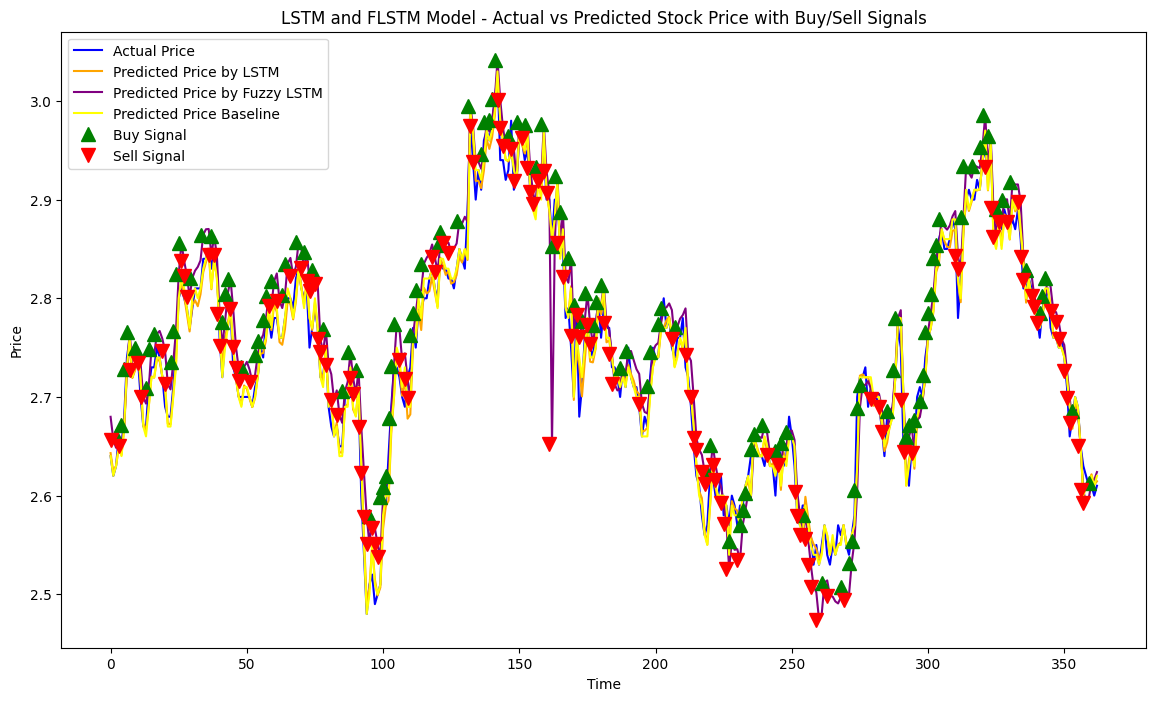

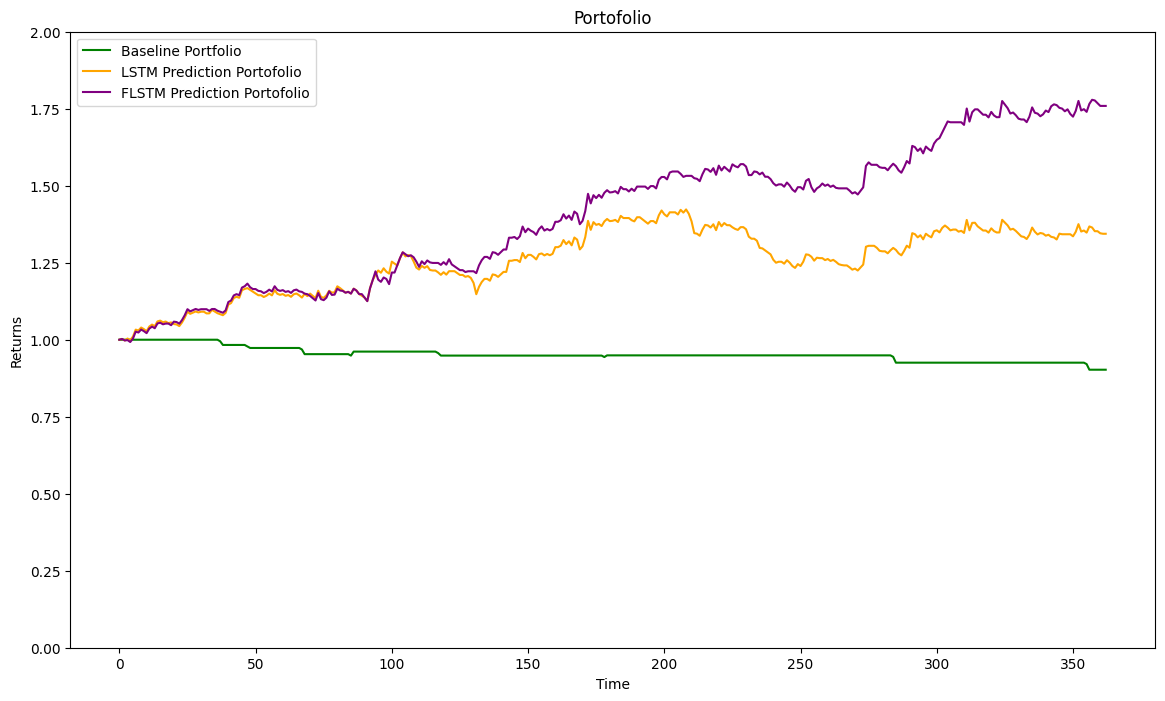

Final portofolio for baseline:  0.9026314130964088
Final portofolio for FLSTM prediction:  1.7591325151665445
Final portofolio for LSTM prediction:  1.3440016642517494


In [15]:
# Plot actual vs predicted price with buy/sell signals
plt.figure(figsize=(14, 8))
plt.plot(y_test_rescaled, label='Actual Price', color='blue')
plt.plot(y_pred_rescaled_LSTM, label='Predicted Price by LSTM', color='orange')
plt.plot(y_pred_rescaled_FLSTM, label='Predicted Price by Fuzzy LSTM', color='purple')
plt.plot(y_pred_baseline, label='Predicted Price Baseline', color='yellow')

plt.plot(FLSTM_pred_buy_signals, marker='^', markersize=10, color='green', linestyle='None', label='Buy Signal')
plt.plot(FLSTM_pred_sell_signals, marker='v', markersize=10, color='red', linestyle='None', label='Sell Signal')
plt.title('LSTM and FLSTM Model - Actual vs Predicted Stock Price with Buy/Sell Signals')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot actual vs predicted price with buy/sell signals
plt.figure(figsize=(14, 8))
plt.ylim((0, 2))
plt.plot(baseline_portfolio, label='Baseline Portfolio', color='green')
plt.plot(LSTM_pred_portfolio, label='LSTM Prediction Portofolio', color='orange')
plt.plot(FLSTM_pred_portfolio, label='FLSTM Prediction Portofolio', color='purple')
plt.title('Portofolio')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()

print("Final portofolio for baseline: ", baseline_portfolio[-1])

print("Final portofolio for FLSTM prediction: ", FLSTM_pred_portfolio[-1])
print("Final portofolio for LSTM prediction: ", LSTM_pred_portfolio[-1])

In [16]:

#Transfer Learning

'''
#Prepare data for new stock

end_date = datetime.today()
start_date = end_date - timedelta(days=3 * 365)
ticker = 'J69U.SI'
df2 = yf.download(ticker, start=start_date, end=end_date)
df2.head()


df2['Price_Diff'] = df2['Close'].diff()
df['Volatility'] = df2['Close'].rolling(window=10).std()

df2['LSTM_Fast_SMA'] = df2['Close'].rolling(window = 7, min_periods = 1).mean()
df2['LSTM_Slow_SMA'] = df2['Close'].rolling(window = 30, min_periods = 1).mean()

df2['Fast_SMA'] = df2['Close'].rolling(window = 20, min_periods = 1).mean()
df2['Slow_SMA'] = df2['Close'].rolling(window = 100, min_periods = 1).mean()

# Drop any rows with NaN values (resulting from the rolling window and differencing)
df2.dropna(inplace=True)

# 2. Prepare the Dataset with Selected Features
features_new = df2[['Close', 'LSTM_Fast_SMA', 'LSTM_Slow_SMA', 'Price_Diff']]

# Normalize the data for stability
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

cluster_centers, cluster_means, cluster_sigmas = clustering_features(scaled_features, features_n_clusters)
it2fmf = generate_it2fmf(cluster_means, cluster_sigmas)


# Split the new dataset into training and testing sets
sequence_length = 30  # Use the last 30 days of data to predict the next day
X, y = [], []
for i in range(sequence_length, len(scaled_features)):
    X.append(scaled_features[i-sequence_length:i])  # Last 30 days of features
    y.append(scaled_features[i, 0])  # Next day's closing price as the target

# Convert lists to numpy arrays
X, y = np.array(X), np.array(y)

# 4. Split the Data into Training and Testing Sets
train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


fuzzy_model.save_weights('fuzzy_model.weights.h5')

fuzzy_layer_new = FuzzyLayer(it2fmf)  # Use the new fuzzy sets generated for 'A179.SI'

transfer_model = tf.keras.Sequential([
    fuzzy_layer_new,  # Use a new fuzzy layer specific to the new stock
    tf.keras.layers.LSTM(16, return_sequences=True, trainable=False),  # Freeze LSTM
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, trainable=False),  # Freeze Dense layers
    tf.keras.layers.LSTM(16, trainable=False),  # Freeze LSTM
    tf.keras.layers.Dense(1)  # Output layer remains trainable
])

# Load the weights from the pretrained model
transfer_model.load_weights('fuzzy_model.weights.h5')

transfer_model.compile(optimizer='adam', loss='mean_squared_error')

history = transfer_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


# New model without saved weights

new_model = tf.keras.Sequential([
    fuzzy_layer_new,  # Use a new fuzzy layer specific to the new stock
    tf.keras.layers.LSTM(16, return_sequences=True, trainable=False),  # Freeze LSTM
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, trainable=False),  # Freeze Dense layers
    tf.keras.layers.LSTM(16, trainable=False),  # Freeze LSTM
    tf.keras.layers.Dense(1)  # Output layer remains trainable
])

new_model.compile(optimizer='adam', loss='mean_squared_error')
history = new_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))
'''

"\n#Prepare data for new stock\n\nend_date = datetime.today()\nstart_date = end_date - timedelta(days=3 * 365)\nticker = 'J69U.SI'\ndf2 = yf.download(ticker, start=start_date, end=end_date)\ndf2.head()\n\n\ndf2['Price_Diff'] = df2['Close'].diff()\ndf['Volatility'] = df2['Close'].rolling(window=10).std()\n\ndf2['LSTM_Fast_SMA'] = df2['Close'].rolling(window = 7, min_periods = 1).mean()\ndf2['LSTM_Slow_SMA'] = df2['Close'].rolling(window = 30, min_periods = 1).mean()\n\ndf2['Fast_SMA'] = df2['Close'].rolling(window = 20, min_periods = 1).mean()\ndf2['Slow_SMA'] = df2['Close'].rolling(window = 100, min_periods = 1).mean()\n\n# Drop any rows with NaN values (resulting from the rolling window and differencing)\ndf2.dropna(inplace=True)\n\n# 2. Prepare the Dataset with Selected Features\nfeatures_new = df2[['Close', 'LSTM_Fast_SMA', 'LSTM_Slow_SMA', 'Price_Diff']]\n\n# Normalize the data for stability\nscaler = MinMaxScaler(feature_range=(0, 1))\nscaled_features = scaler.fit_transform(featur

In [17]:
'''
y_pred_transfer = transfer_model.predict(X_test)
y_pred_new = new_model.predict(X_test)


price_change_threshold = 0.001

transfer_pred_buy_signals, transfer_pred_sell_signals = calculate_transaction_signals(y_pred_transfer, y_test_rescaled, price_change_threshold)
transfer_pred_portfolio = calculate_portfolio(transfer_pred_buy_signals, transfer_pred_sell_signals, y_test_rescaled, transaction_rate)

new_pred_buy_signals, new_pred_sell_signals = calculate_transaction_signals(y_pred_new, y_test_rescaled, price_change_threshold)
new_pred_portfolio = calculate_portfolio(new_pred_buy_signals, new_pred_sell_signals, y_test_rescaled, transaction_rate)

plt.figure(figsize=(14, 8))
plt.ylim((0, 1.5))

plt.plot(transfer_pred_portfolio, label='Transfer Learning Prediction Portofolio', color='orange')
plt.plot(new_pred_portfolio, label='New Model Prediction Portofolio', color='purple')
plt.title('Portofolio')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()

print("Final portofolio for baseline: ", baseline_portfolio[-1])

print("Final portofolio for transfer learning prediction: ", transfer_pred_portfolio[-1])
print("Final portofolio for new model prediction: ", new_pred_portfolio[-1])
'''

'\ny_pred_transfer = transfer_model.predict(X_test)\ny_pred_new = new_model.predict(X_test)\n\n\nprice_change_threshold = 0.001\n\ntransfer_pred_buy_signals, transfer_pred_sell_signals = calculate_transaction_signals(y_pred_transfer, y_test_rescaled, price_change_threshold)\ntransfer_pred_portfolio = calculate_portfolio(transfer_pred_buy_signals, transfer_pred_sell_signals, y_test_rescaled, transaction_rate)\n\nnew_pred_buy_signals, new_pred_sell_signals = calculate_transaction_signals(y_pred_new, y_test_rescaled, price_change_threshold)\nnew_pred_portfolio = calculate_portfolio(new_pred_buy_signals, new_pred_sell_signals, y_test_rescaled, transaction_rate)\n\nplt.figure(figsize=(14, 8))\nplt.ylim((0, 1.5))\n\nplt.plot(transfer_pred_portfolio, label=\'Transfer Learning Prediction Portofolio\', color=\'orange\')\nplt.plot(new_pred_portfolio, label=\'New Model Prediction Portofolio\', color=\'purple\')\nplt.title(\'Portofolio\')\nplt.xlabel(\'Time\')\nplt.ylabel(\'Returns\')\nplt.legend(